In [1]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers scikit-learn matplotlib seaborn pandas numpy

from google.colab import drive
drive.mount('/content/drive')

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import os
import re
import pickle
import json

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Setup complete - Device: {device}")

Setting up...
Mounted at /content/drive
Setup complete - Device: cpu


In [2]:
# LOAD ALL THREE DETECTORS

print("Loading all three detectors...\n")

# 1. Perplexity Detector
print("1. Loading Perplexity Detector...")
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.to(device)
gpt2_model.eval()

with open('results/perplexity_detector_results.json', 'r') as f:
    perplexity_threshold = json.load(f)['threshold']

def calculate_perplexity(text):
    encodings = gpt2_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

def perplexity_predict_proba(text):
    ppl = calculate_perplexity(text)
    # Convert perplexity to probability
    # Lower perplexity = higher probability of AI
    ai_prob = 1 / (1 + np.exp((ppl - perplexity_threshold) / 10))
    return np.array([1 - ai_prob, ai_prob])

print(f" Loaded (threshold: {perplexity_threshold:.2f})")

# 2. Statistical Detector
print("\n2. Loading Statistical Detector...")
with open('models/statistical_detector.pkl', 'rb') as f:
    statistical_data = pickle.load(f)

statistical_model = statistical_data['model']
scaler = statistical_data['scaler']
feature_names = statistical_data['feature_names']

def extract_features(text):
    words = text.split()
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    char_count = len(text)
    alpha_count = sum(c.isalpha() for c in text)
    digit_count = sum(c.isdigit() for c in text)
    punct_count = sum(c in '.,!?;:\'"' for c in text)
    upper_count = sum(c.isupper() for c in text)
    word_count = len(words)
    unique_words = len(set(words))
    sentence_count = len(sentences)

    stopwords = {'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i'}
    transition_words = {'however', 'therefore', 'furthermore', 'moreover'}
    personal_pronouns = {'i', 'me', 'my', 'mine', 'we', 'us', 'our'}

    stopword_count = sum(1 for w in words if w.lower() in stopwords)
    transition_count = sum(1 for w in words if w.lower() in transition_words)
    pronoun_count = sum(1 for w in words if w.lower() in personal_pronouns)

    from collections import Counter
    word_freq = Counter(words)

    features = {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'avg_sentence_length': word_count / sentence_count if sentence_count > 0 else 0,
        'sentence_length_variance': np.var([len(s.split()) for s in sentences]) if len(sentences) > 1 else 0,
        'lexical_diversity': unique_words / word_count if word_count > 0 else 0,
        'unique_word_ratio': unique_words / word_count if word_count > 0 else 0,
        'punct_ratio': punct_count / char_count if char_count > 0 else 0,
        'comma_ratio': text.count(',') / char_count if char_count > 0 else 0,
        'period_ratio': text.count('.') / char_count if char_count > 0 else 0,
        'question_ratio': text.count('?') / char_count if char_count > 0 else 0,
        'upper_ratio': upper_count / alpha_count if alpha_count > 0 else 0,
        'digit_ratio': digit_count / char_count if char_count > 0 else 0,
        'stopword_ratio': stopword_count / word_count if word_count > 0 else 0,
        'transition_ratio': transition_count / word_count if word_count > 0 else 0,
        'pronoun_ratio': pronoun_count / word_count if word_count > 0 else 0,
        'word_freq_variance': np.var(list(word_freq.values())) if word_freq else 0,
    }

    return [features[fn] for fn in feature_names]

def statistical_predict_proba(text):
    features = np.array(extract_features(text)).reshape(1, -1)
    features_scaled = scaler.transform(features)
    return statistical_model.predict_proba(features_scaled)[0]

print(f"   Loaded ({statistical_data['best_model_name']})")

# 3. Classifier Detector
print("\n3. Loading Classifier Detector...")
classifier_tokenizer = AutoTokenizer.from_pretrained('models/classifier_final')
classifier_model = AutoModelForSequenceClassification.from_pretrained('models/classifier_final')
classifier_model.to(device)
classifier_model.eval()

def classifier_predict_proba(text):
    inputs = classifier_tokenizer(text, return_tensors='pt', truncation=True, max_length=256, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = classifier_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    return probs

print("   Loaded (DistilBERT)")

print("\n")
print("All three detectors loaded and ready!")

Loading all three detectors...

1. Loading Perplexity Detector...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

 Loaded (threshold: 34.00)

2. Loading Statistical Detector...
   Loaded (Random Forest)

3. Loading Classifier Detector...
   Loaded (DistilBERT)


All three detectors loaded and ready!


In [3]:
# LOAD TEST DATA

print("Loading test data...")

df = pd.read_csv('data/complete_dataset.csv')
df['label_numeric'] = (df['label'] == 'ai').astype(int)

# Use same train/test split as before
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_numeric']
)

print(f"\nTest set: {len(test_df)} samples")
print(f"  Human: {len(test_df[test_df['label']=='human'])}")
print(f"  AI:    {len(test_df[test_df['label']=='ai'])}")

X_test = test_df['text'].values
y_test = test_df['label_numeric'].values

Loading test data...

Test set: 211 samples
  Human: 92
  AI:    119


In [4]:
# GET PREDICTIONS FROM ALL DETECTORS

print("Getting predictions from all three detectors...")

perplexity_probs = []
statistical_probs = []
classifier_probs = []

for idx, text in enumerate(X_test):
    # Perplexity
    ppl_prob = perplexity_predict_proba(text)
    perplexity_probs.append(ppl_prob)

    # Statistical
    stat_prob = statistical_predict_proba(text)
    statistical_probs.append(stat_prob)

    # Classifier
    cls_prob = classifier_predict_proba(text)
    classifier_probs.append(cls_prob)

    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(X_test)}")

perplexity_probs = np.array(perplexity_probs)
statistical_probs = np.array(statistical_probs)
classifier_probs = np.array(classifier_probs)

print(f"\n Collected predictions from all detectors")
print(f"   Shape: {perplexity_probs.shape}")

Getting predictions from all three detectors...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  Processed 50/211
  Processed 100/211
  Processed 150/211
  Processed 200/211

 Collected predictions from all detectors
   Shape: (211, 2)


In [5]:
# ENSEMBLE METHOD 1: SIMPLE AVERAGE

print("Method 1: Simple Average Ensemble\n")

# Average probabilities
avg_probs = (perplexity_probs + statistical_probs + classifier_probs) / 3

# Predict class
avg_preds = np.argmax(avg_probs, axis=1)

# Evaluate
avg_acc = accuracy_score(y_test, avg_preds)
avg_prec = precision_score(y_test, avg_preds)
avg_rec = recall_score(y_test, avg_preds)
avg_f1 = f1_score(y_test, avg_preds)

print("Simple Average Ensemble Results:")
print(f"  Accuracy:  {avg_acc:.1%}")
print(f"  Precision: {avg_prec:.1%}")
print(f"  Recall:    {avg_rec:.1%}")
print(f"  F1 Score:  {avg_f1:.3f}")

# Compare with individual detectors
print("\nComparison with Individual Detectors:")
print(f"  Perplexity:  {accuracy_score(y_test, np.argmax(perplexity_probs, axis=1)):.1%}")
print(f"  Statistical: {accuracy_score(y_test, np.argmax(statistical_probs, axis=1)):.1%}")
print(f"  Classifier:  {accuracy_score(y_test, np.argmax(classifier_probs, axis=1)):.1%}")
print(f"  → Ensemble:  {avg_acc:.1%}")

improvement = avg_acc - max(
    accuracy_score(y_test, np.argmax(perplexity_probs, axis=1)),
    accuracy_score(y_test, np.argmax(statistical_probs, axis=1)),
    accuracy_score(y_test, np.argmax(classifier_probs, axis=1))
)

print(f"\nImprovement: {improvement*100:+.1f}% over best individual detector")

Method 1: Simple Average Ensemble

Simple Average Ensemble Results:
  Accuracy:  99.5%
  Precision: 100.0%
  Recall:    99.2%
  F1 Score:  0.996

Comparison with Individual Detectors:
  Perplexity:  79.1%
  Statistical: 93.4%
  Classifier:  99.5%
  → Ensemble:  99.5%

Improvement: +0.0% over best individual detector


In [6]:
# ENSEMBLE METHOD 2: WEIGHTED AVERAGE

print("Method 2: Weighted Average Ensemble\n")

# Load individual detector performance from results
with open('results/perplexity_detector_results.json', 'r') as f:
    ppl_f1 = json.load(f)['f1']

with open('results/statistical_detector_results.json', 'r') as f:
    stat_f1 = json.load(f)['f1']

with open('results/classifier_results.json', 'r') as f:
    cls_f1 = json.load(f)['f1']

# Normalize weights based on F1 scores
total_f1 = ppl_f1 + stat_f1 + cls_f1
w_ppl = ppl_f1 / total_f1
w_stat = stat_f1 / total_f1
w_cls = cls_f1 / total_f1

print(f"Weights based on F1 scores:")
print(f"  Perplexity:  {w_ppl:.3f} (F1={ppl_f1:.3f})")
print(f"  Statistical: {w_stat:.3f} (F1={stat_f1:.3f})")
print(f"  Classifier:  {w_cls:.3f} (F1={cls_f1:.3f})")

# Weighted average
weighted_probs = (w_ppl * perplexity_probs +
                  w_stat * statistical_probs +
                  w_cls * classifier_probs)

weighted_preds = np.argmax(weighted_probs, axis=1)

# Evaluate
weighted_acc = accuracy_score(y_test, weighted_preds)
weighted_prec = precision_score(y_test, weighted_preds)
weighted_rec = recall_score(y_test, weighted_preds)
weighted_f1 = f1_score(y_test, weighted_preds)

print(f"\nWeighted Average Ensemble Results:")
print(f"  Accuracy:  {weighted_acc:.1%}")
print(f"  Precision: {weighted_prec:.1%}")
print(f"  Recall:    {weighted_rec:.1%}")
print(f"  F1 Score:  {weighted_f1:.3f}")

improvement = weighted_acc - avg_acc
print(f"\nImprovement over simple average: {improvement*100:+.1f}%")

Method 2: Weighted Average Ensemble

Weights based on F1 scores:
  Perplexity:  0.298 (F1=0.824)
  Statistical: 0.342 (F1=0.944)
  Classifier:  0.360 (F1=0.996)

Weighted Average Ensemble Results:
  Accuracy:  99.5%
  Precision: 100.0%
  Recall:    99.2%
  F1 Score:  0.996

Improvement over simple average: +0.0%


In [7]:
# ENSEMBLE METHOD 3: ADAPTIVE (TEXT-LENGTH BASED)

print("Method 3: Adaptive Ensemble (Text-Length Based)\n")

def adaptive_predict(text, ppl_prob, stat_prob, cls_prob):
    """
    Adaptive weighting based on text characteristics
    """
    word_count = len(text.split())

    if word_count < 50:
        # Short text: Perplexity works better
        weights = [0.4, 0.3, 0.3]
    elif word_count < 150:
        # Medium text: Balanced
        weights = [0.3, 0.35, 0.35]
    else:
        # Long text: Classifier works better
        weights = [0.2, 0.3, 0.5]

    combined = (weights[0] * ppl_prob +
                weights[1] * stat_prob +
                weights[2] * cls_prob)

    return np.argmax(combined)

print("Applying adaptive weighting based on text length...")

adaptive_preds = []
for idx, text in enumerate(X_test):
    pred = adaptive_predict(
        text,
        perplexity_probs[idx],
        statistical_probs[idx],
        classifier_probs[idx]
    )
    adaptive_preds.append(pred)

adaptive_preds = np.array(adaptive_preds)

# Evaluate
adaptive_acc = accuracy_score(y_test, adaptive_preds)
adaptive_prec = precision_score(y_test, adaptive_preds)
adaptive_rec = recall_score(y_test, adaptive_preds)
adaptive_f1 = f1_score(y_test, adaptive_preds)

print(f"\nAdaptive Ensemble Results:")
print(f"  Accuracy:  {adaptive_acc:.1%}")
print(f"  Precision: {adaptive_prec:.1%}")
print(f"  Recall:    {adaptive_rec:.1%}")
print(f"  F1 Score:  {adaptive_f1:.3f}")

print(f"\nText length distribution in test set:")
word_counts = [len(text.split()) for text in X_test]
print(f"  Short (<50):     {sum(1 for wc in word_counts if wc < 50)}")
print(f"  Medium (50-150): {sum(1 for wc in word_counts if 50 <= wc < 150)}")
print(f"  Long (>150):     {sum(1 for wc in word_counts if wc >= 150)}")

Method 3: Adaptive Ensemble (Text-Length Based)

Applying adaptive weighting based on text length...

Adaptive Ensemble Results:
  Accuracy:  99.5%
  Precision: 100.0%
  Recall:    99.2%
  F1 Score:  0.996

Text length distribution in test set:
  Short (<50):     9
  Medium (50-150): 147
  Long (>150):     55


In [8]:
# ENSEMBLE METHOD 4: CONFIDENCE-BASED

print("Method 4: Confidence-Based Ensemble\n")

def confidence_based_predict(ppl_prob, stat_prob, cls_prob):
    """
    Weight by confidence (how far from 0.5)
    More confident predictions get more weight
    """
    # Calculate confidence for each detector
    ppl_conf = abs(ppl_prob[1] - 0.5)
    stat_conf = abs(stat_prob[1] - 0.5)
    cls_conf = abs(cls_prob[1] - 0.5)

    # Normalize confidences to weights
    total_conf = ppl_conf + stat_conf + cls_conf

    if total_conf == 0:
        # All equally uncertain, use equal weights
        weights = [1/3, 1/3, 1/3]
    else:
        weights = [ppl_conf/total_conf, stat_conf/total_conf, cls_conf/total_conf]

    combined = (weights[0] * ppl_prob +
                weights[1] * stat_prob +
                weights[2] * cls_prob)

    return np.argmax(combined)

print("Applying confidence-based weighting...")

confidence_preds = []
for idx in range(len(X_test)):
    pred = confidence_based_predict(
        perplexity_probs[idx],
        statistical_probs[idx],
        classifier_probs[idx]
    )
    confidence_preds.append(pred)

confidence_preds = np.array(confidence_preds)

# Evaluate
confidence_acc = accuracy_score(y_test, confidence_preds)
confidence_prec = precision_score(y_test, confidence_preds)
confidence_rec = recall_score(y_test, confidence_preds)
confidence_f1 = f1_score(y_test, confidence_preds)

print(f"\nConfidence-Based Ensemble Results:")
print(f"  Accuracy:  {confidence_acc:.1%}")
print(f"  Precision: {confidence_prec:.1%}")
print(f"  Recall:    {confidence_rec:.1%}")
print(f"  F1 Score:  {confidence_f1:.3f}")

print("\nConcept: More confident detectors get more weight")
print("If one detector is very confident (0.9) and others uncertain (0.55),")
print("the confident one dominates the decision")

Method 4: Confidence-Based Ensemble

Applying confidence-based weighting...

Confidence-Based Ensemble Results:
  Accuracy:  99.5%
  Precision: 100.0%
  Recall:    99.2%
  F1 Score:  0.996

Concept: More confident detectors get more weight
If one detector is very confident (0.9) and others uncertain (0.55),
the confident one dominates the decision


In [9]:
# ENSEMBLE METHOD 5: MAJORITY VOTING

print("Method 5: Majority Voting\n")

# Get hard predictions from each detector
ppl_preds = np.argmax(perplexity_probs, axis=1)
stat_preds = np.argmax(statistical_probs, axis=1)
cls_preds = np.argmax(classifier_probs, axis=1)

# Majority vote
voting_preds = []
for i in range(len(X_test)):
    votes = [ppl_preds[i], stat_preds[i], cls_preds[i]]
    # Most common vote
    majority = max(set(votes), key=votes.count)
    voting_preds.append(majority)

voting_preds = np.array(voting_preds)

# Evaluate
voting_acc = accuracy_score(y_test, voting_preds)
voting_prec = precision_score(y_test, voting_preds)
voting_rec = recall_score(y_test, voting_preds)
voting_f1 = f1_score(y_test, voting_preds)

print(f"Majority Voting Ensemble Results:")
print(f"  Accuracy:  {voting_acc:.1%}")
print(f"  Precision: {voting_prec:.1%}")
print(f"  Recall:    {voting_rec:.1%}")
print(f"  F1 Score:  {voting_f1:.3f}")

# Check agreement
all_agree = sum(1 for i in range(len(X_test)) if len(set([ppl_preds[i], stat_preds[i], cls_preds[i]])) == 1)
two_agree = sum(1 for i in range(len(X_test)) if len(set([ppl_preds[i], stat_preds[i], cls_preds[i]])) == 2)
all_disagree = sum(1 for i in range(len(X_test)) if len(set([ppl_preds[i], stat_preds[i], cls_preds[i]])) == 3)

print(f"\nDetector Agreement:")
print(f"  All 3 agree:    {all_agree}/{len(X_test)} ({all_agree/len(X_test):.1%})")
print(f"  2 agree:        {two_agree}/{len(X_test)} ({two_agree/len(X_test):.1%})")
print(f"  All disagree:   {all_disagree}/{len(X_test)} ({all_disagree/len(X_test):.1%})")

print("\nNote: When all disagree, voting picks one arbitrarily")

Method 5: Majority Voting

Majority Voting Ensemble Results:
  Accuracy:  99.1%
  Precision: 99.2%
  Recall:    99.2%
  F1 Score:  0.992

Detector Agreement:
  All 3 agree:    154/211 (73.0%)
  2 agree:        57/211 (27.0%)
  All disagree:   0/211 (0.0%)

Note: When all disagree, voting picks one arbitrarily


In [10]:
# COMPARE ALL ENSEMBLE METHODS

print("Comparing all methods...\n")

results_comparison = pd.DataFrame({
    'Method': [
        'Perplexity (Individual)',
        'Statistical (Individual)',
        'Classifier (Individual)',
        'Simple Average',
        'Weighted Average',
        'Adaptive',
        'Confidence-Based',
        'Majority Voting'
    ],
    'Accuracy': [
        accuracy_score(y_test, np.argmax(perplexity_probs, axis=1)),
        accuracy_score(y_test, np.argmax(statistical_probs, axis=1)),
        accuracy_score(y_test, np.argmax(classifier_probs, axis=1)),
        avg_acc,
        weighted_acc,
        adaptive_acc,
        confidence_acc,
        voting_acc
    ],
    'F1': [
        f1_score(y_test, np.argmax(perplexity_probs, axis=1)),
        f1_score(y_test, np.argmax(statistical_probs, axis=1)),
        f1_score(y_test, np.argmax(classifier_probs, axis=1)),
        avg_f1,
        weighted_f1,
        adaptive_f1,
        confidence_f1,
        voting_f1
    ]
})

results_comparison = results_comparison.sort_values('F1', ascending=False)

print("COMPREHENSIVE COMPARISON")
print(results_comparison.to_string(index=False))

best_method = results_comparison.iloc[0]['Method']
best_f1 = results_comparison.iloc[0]['F1']

print(f"\nBest Method: {best_method}")
print(f"   F1 Score: {best_f1:.3f}")
print(f"   Accuracy: {results_comparison.iloc[0]['Accuracy']:.1%}")

Comparing all methods...

COMPREHENSIVE COMPARISON
                  Method  Accuracy       F1
          Simple Average  0.995261 0.995781
 Classifier (Individual)  0.995261 0.995781
                Adaptive  0.995261 0.995781
        Weighted Average  0.995261 0.995781
        Confidence-Based  0.995261 0.995781
         Majority Voting  0.990521 0.991597
Statistical (Individual)  0.933649 0.939130
 Perplexity (Individual)  0.791469 0.824000

Best Method: Simple Average
   F1 Score: 0.996
   Accuracy: 99.5%


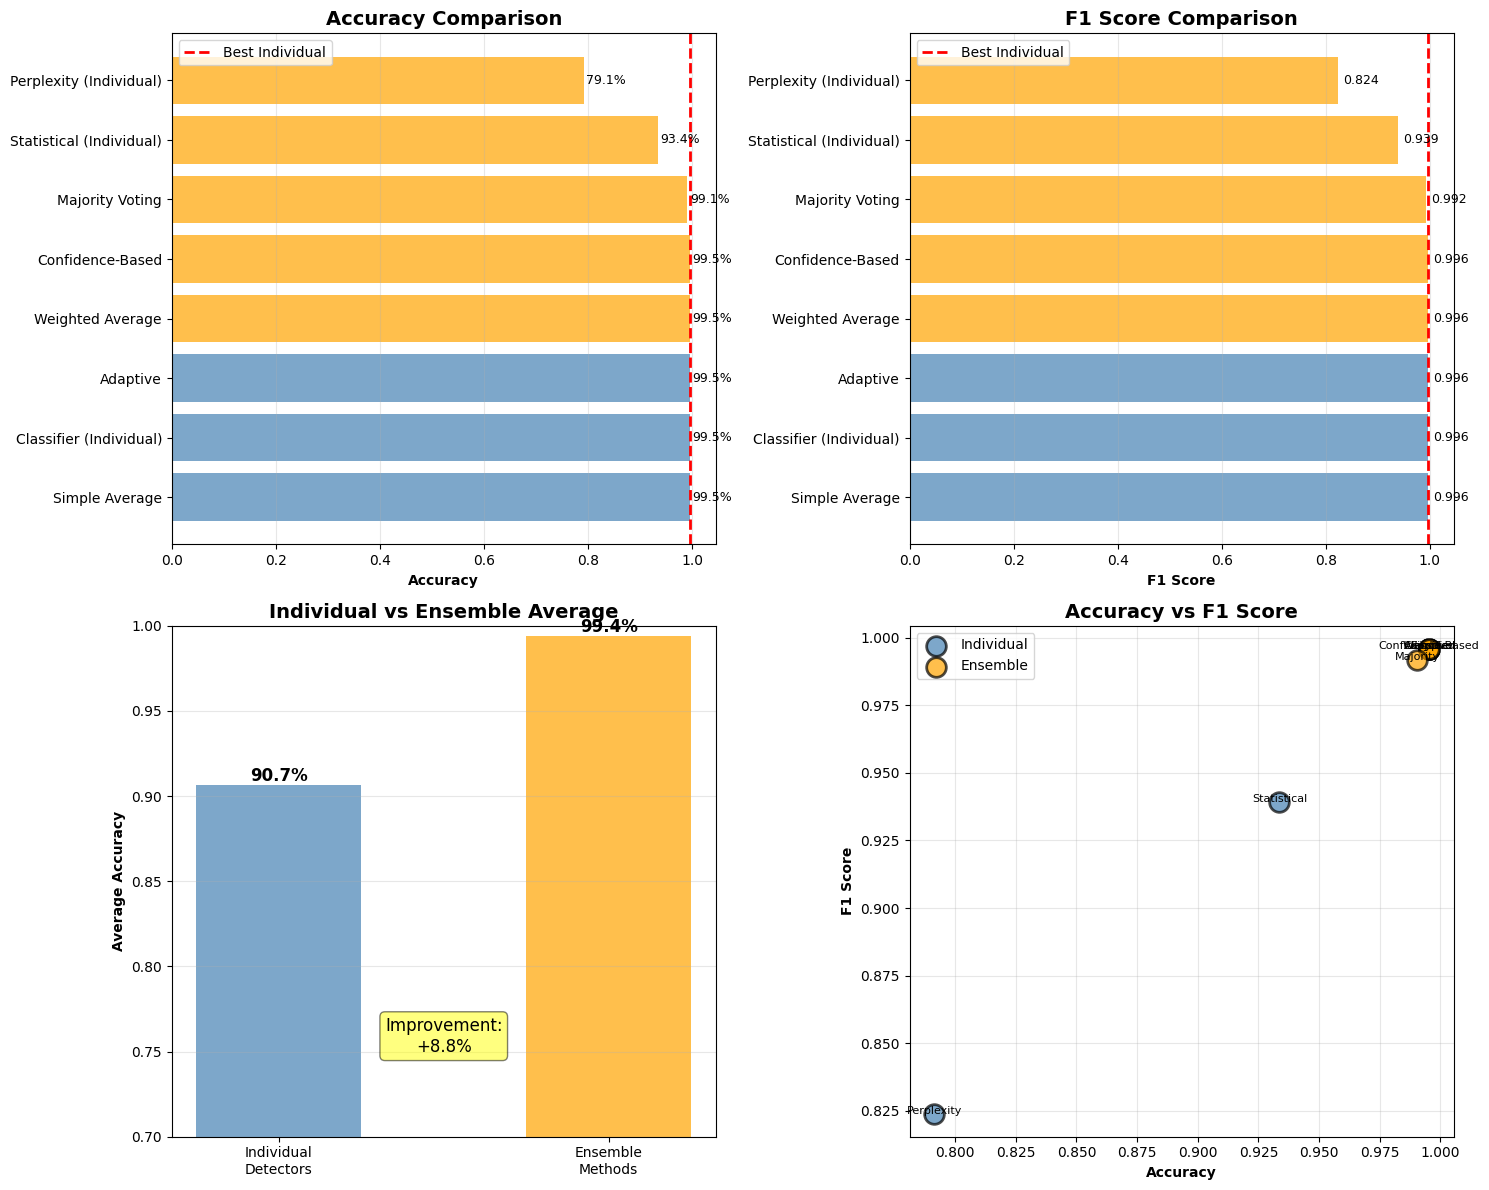

 Visualization saved


In [11]:
# VISUALIZE COMPARISON

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Bar chart of accuracy
ax1 = axes[0, 0]
colors = ['steelblue'] * 3 + ['orange'] * 5
bars = ax1.barh(results_comparison['Method'], results_comparison['Accuracy'], color=colors, alpha=0.7)
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
ax1.axvline(x=results_comparison['Accuracy'].iloc[3], color='red', linestyle='--',
            label='Best Individual', linewidth=2)
ax1.legend()
ax1.grid(alpha=0.3, axis='x')

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.1%}', ha='left', va='center', fontsize=9)

# Plot 2: F1 scores
ax2 = axes[0, 1]
bars = ax2.barh(results_comparison['Method'], results_comparison['F1'], color=colors, alpha=0.7)
ax2.set_xlabel('F1 Score', fontweight='bold')
ax2.set_title('F1 Score Comparison', fontweight='bold', fontsize=14)
ax2.axvline(x=results_comparison['F1'].iloc[3], color='red', linestyle='--',
            label='Best Individual', linewidth=2)
ax2.legend()
ax2.grid(alpha=0.3, axis='x')

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# Plot 3: Individual vs Ensemble comparison
ax3 = axes[1, 0]
individual_avg = results_comparison[results_comparison['Method'].str.contains('Individual')]['Accuracy'].mean()
ensemble_avg = results_comparison[~results_comparison['Method'].str.contains('Individual')]['Accuracy'].mean()

categories = ['Individual\nDetectors', 'Ensemble\nMethods']
values = [individual_avg, ensemble_avg]
bars = ax3.bar(categories, values, color=['steelblue', 'orange'], alpha=0.7, width=0.5)
ax3.set_ylabel('Average Accuracy', fontweight='bold')
ax3.set_title('Individual vs Ensemble Average', fontweight='bold', fontsize=14)
ax3.set_ylim([0.7, 1.0])
ax3.grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

improvement = ensemble_avg - individual_avg
ax3.text(0.5, 0.75, f'Improvement:\n+{improvement*100:.1f}%',
         ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Plot 4: Scatter - Accuracy vs F1
ax4 = axes[1, 1]
individual_mask = results_comparison['Method'].str.contains('Individual')
ax4.scatter(results_comparison[individual_mask]['Accuracy'],
            results_comparison[individual_mask]['F1'],
            s=200, c='steelblue', alpha=0.7, label='Individual', edgecolors='black', linewidth=2)
ax4.scatter(results_comparison[~individual_mask]['Accuracy'],
            results_comparison[~individual_mask]['F1'],
            s=200, c='orange', alpha=0.7, label='Ensemble', edgecolors='black', linewidth=2)

for idx, row in results_comparison.iterrows():
    ax4.annotate(row['Method'].split()[0],
                (row['Accuracy'], row['F1']),
                fontsize=8, ha='center')

ax4.set_xlabel('Accuracy', fontweight='bold')
ax4.set_ylabel('F1 Score', fontweight='bold')
ax4.set_title('Accuracy vs F1 Score', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Visualization saved")

Selecting best ensemble method...

Best Method: Simple Average


BEST ENSEMBLE - DETAILED EVALUATION

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99        92
          AI       1.00      0.99      1.00       119

    accuracy                           1.00       211
   macro avg       0.99      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211


Confusion Matrix:
  True Negatives:  92
  False Positives: 0
  False Negatives: 1
  True Positives:  118

Error Analysis:
  Missed AI (false negatives): 1/119 (0.8%)
  False alarms (false positives): 0/92 (0.0%)


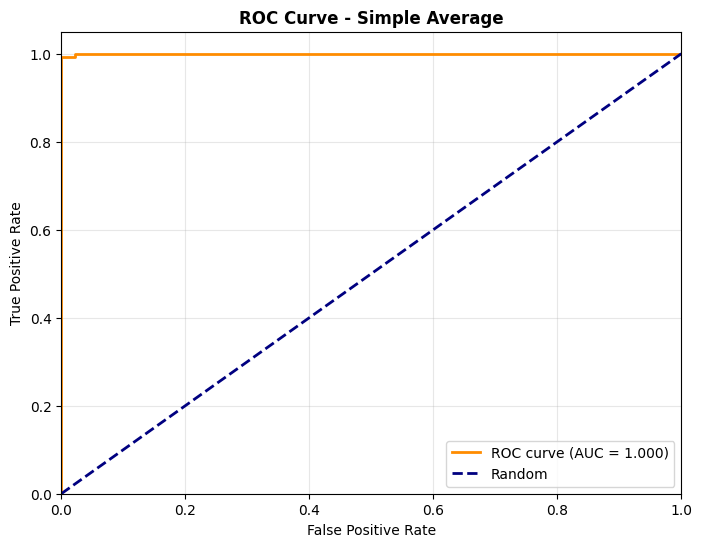


 AUC Score: 1.000


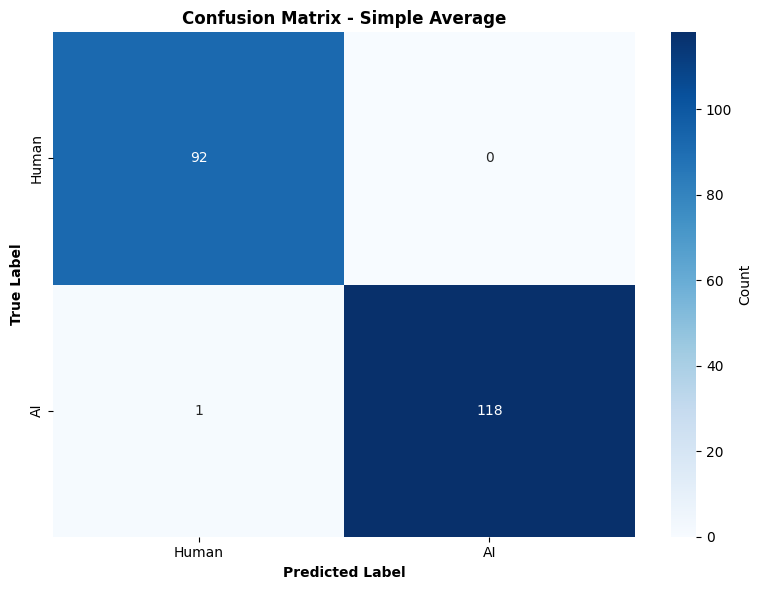


Visualizations saved


In [12]:
# SELECT BEST ENSEMBLE AND EVALUATE

print("Selecting best ensemble method...\n")

best_method_name = results_comparison.iloc[0]['Method']
print(f"Best Method: {best_method_name}")

# Get predictions from best method
if 'Adaptive' in best_method_name:
    best_preds = adaptive_preds
    best_probs = None  # Can't easily get probs for adaptive
elif 'Confidence' in best_method_name:
    best_preds = confidence_preds
    best_probs = None
elif 'Voting' in best_method_name:
    best_preds = voting_preds
    best_probs = None
elif 'Weighted' in best_method_name:
    best_preds = weighted_preds
    best_probs = weighted_probs
else:  # Simple Average
    best_preds = avg_preds
    best_probs = avg_probs

# Comprehensive evaluation
print("\n")
print("BEST ENSEMBLE - DETAILED EVALUATION")

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, best_preds, target_names=['Human', 'AI']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_preds)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")

print(f"\nError Analysis:")
print(f"  Missed AI (false negatives): {fn}/{fn+tp} ({fn/(fn+tp):.1%})")
print(f"  False alarms (false positives): {fp}/{fp+tn} ({fp/(fp+tn):.1%})")

# ROC Curve (if probs available)
if best_probs is not None:
    fpr, tpr, thresholds = roc_curve(y_test, best_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_method_name}', fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('results/roc_curve_best_ensemble.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n AUC Score: {roc_auc:.3f}")
else:
    print("\n(ROC curve not available for this ensemble method)")

# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title(f'Confusion Matrix - {best_method_name}', fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix_best_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualizations saved")